In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import glob
import PIL
import webdataset as wds
import os
import os.path
import io
from ocrlib import extract_seg
from random import randrange
import re
import sys
import scipy.ndimage as ndi
from lxml import html

In [8]:

def get_text(node):
    textnodes = node.xpath('.//text()')
    s = ''.join([text for text in textnodes])
    return re.sub(r'\s+', ' ', s)


def get_prop(node, name):
    title = node.get("title")
    props = title.split(';')
    for prop in props:
        (key, args) = prop.split(None, 1)
        args = args.strip('"')
        if key == name:
            return args
    return None

In [9]:
src = iter(wds.Dataset("uw3/uw3-hocr.tar").decode())

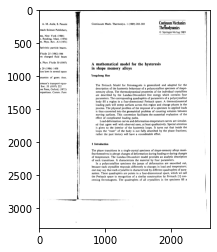

In [10]:
for i, sample in enumerate(src):
    break
sample.keys()
imshow(sample["page.jpg"])

In [11]:
sample["hocr.html"]

b"<html>\n<head>\n<meta name='langs' content='English'>\n<meta name='scripts' content='Roman'>\n<meta name='character_orientation' content='up-right'>\n<meta name='degradation_type' content='photocopy'>\n<meta name='document_type' content='journal'>\n<meta name='publication_name' content='Continuum Mechanics and Thermodynamics'>\n<meta name='publication_date' content='November 89'>\n<meta name='page_id' content='A001'>\n<meta name='page_number' content='283'>\n<meta name='text_reading_direction' content='left-right'>\n<meta name='displayed_math_present' content='N'>\n<meta name='dominant_font_type' content='serif'>\n<meta name='dominant_font_style' content='plain'>\n<meta name='dominant_font_spacing' content='proportional'>\n<meta name='dominant_font_size' content='9-12'>\n<meta name='drawing_present' content='N'>\n<meta name='extras_top_edge' content='Y'>\n<meta name='extras_left_edge' content='Y'>\n<meta name='extras_right_edge' content='Y'>\n<meta name='extras_bottom_edge' content='

In [12]:
def extract_boxes(page, boxes, pad=5):
    #for y0, y1, x0, x1 in boxes:
    for x0, y0, x1, y1 in boxes:
        h, w = y1-y0, x1-x0
        word = ndi.affine_transform(page, np.eye(3), output_shape=(h+2*pad, w+2*pad, 3), offset=(y0-pad, x0-pad, 0), order=0)
        yield word

In [13]:
def get_lines(hocr):
    doc = html.parse(io.StringIO(hocr))
    for line in doc.xpath("//*[@class='ocr_line']"):
        text = get_text(line)
        bbox = [int(x) for x in get_prop(line, "bbox").split()]
        yield (bbox, text)
        #print(re.sub(r'\s+', '\x20', line.text_content()).strip())
        
lines = list(get_lines(sample["hocr.html"].decode("utf-8")))
images = list(extract_boxes(sample["page.jpg"], [x[0] for x in lines]))

([861, 1217, 2241, 1260], 'memory alloys. The thermodynamical properties of the individual crystallites')


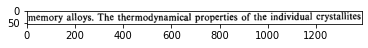

In [14]:
imshow(images[10])
print(lines[10])

In [15]:
sink = wds.TarWriter("uw3/uw3-rawlines.tar")
fcount = 0
for i, sample in enumerate(wds.Dataset("uw3/uw3-hocr.tar").decode()):
    key = sample["__key__"]
    if fcount%100==0:
        print(fcount, key)
    lines = list(get_lines(sample["hocr.html"].decode("utf-8")))
    images = list(extract_boxes(sample["page.jpg"], [x[0] for x in lines]))
    assert len(lines) == len(images)
    count = 0
    for (bbox, txt), image in zip(lines, images):
        count += 1
        result = {
            "__key__": f"{key}-{count}",
            "bbox.json": bbox,
            "gt.txt": txt,
            "line.png": image
        }
        sink.write(result)
    fcount += 1
sink.close()

0 A001
100 A063
200 D038
300 E009
400 E048
500 H048
600 IG0F
700 K00F
800 N04L
900 S02N
1000 W020
1100 W0C3
1200 W0L3
1300 W114
1400 W1B1
1500 W1K2


In [18]:
!tarp cat -s 20000 uw3/uw3-rawlines.tar -o - | tarp split -c 5000 - -o uw3/uw3-rawlines-%06d.tar

[progress] # source -
[info] # shuffle 20000
[progress] # writing -
[progress] # source uw3/uw3-rawlines.tar
[progress] # shard uw3/uw3-rawlines-000000.tar
[progress] # shard uw3/uw3-rawlines-000001.tar
[progress] # shard uw3/uw3-rawlines-000002.tar
[progress] # shard uw3/uw3-rawlines-000003.tar
[progress] # shard uw3/uw3-rawlines-000004.tar
[progress] # shard uw3/uw3-rawlines-000005.tar
[progress] # shard uw3/uw3-rawlines-000006.tar
[progress] # shard uw3/uw3-rawlines-000007.tar
[progress] # shard uw3/uw3-rawlines-000008.tar
[progress] # shard uw3/uw3-rawlines-000009.tar
[progress] # shard uw3/uw3-rawlines-000010.tar
[progress] # shard uw3/uw3-rawlines-000011.tar
[progress] # shard uw3/uw3-rawlines-000012.tar
[progress] # shard uw3/uw3-rawlines-000013.tar
[progress] # shard uw3/uw3-rawlines-000014.tar
[progress] # shard uw3/uw3-rawlines-000015.tar
[progress] # shard uw3/uw3-rawlines-000016.tar
[progress] # shard uw3/uw3-rawlines-000017.tar
[progress] # shard uw3/uw3-rawlines-000018.ta